In [ ]:
!pip install ujson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gc
import copy
import numpy as np
import pandas as pd
import random
import ujson
from torch.utils.data import Dataset, DataLoader
from PIL import Image

def set_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

REPRODUCIBLE_SEED = 42
set_everything(REPRODUCIBLE_SEED)

BATCH_SIZE = 64
LATENT_UPSAMPLE = 128
L1_LAMBDA = 2
CLIP_MODEL_SIZE = 768
KANDINSKY_MODEL_SIZE = 1280

### Classes

#### Trainer

In [ ]:
class Trainer():
    """
    required libs:
    torch, gc, matplotlib, copy, tqdm, numpy
    """
    def __init__(self,
                 model,
                 optimizer, scheduler,
                 train_loader, eval_loader,
                 n_epochs:int=1, max_overfit:int=3, path_to_dict:str="best_model.pth"
    ):
        super().__init__()
        self._device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self._metrics = {}
        self._metrics_temp = {"train": [], "eval": []}
        self._metrics_names = model.get_metrics_names().copy()
        self.set_new_model(model, optimizer, scheduler)
        self.set_dataloaders(train_loader, eval_loader)

        self.set_num_epochs(n_epochs)
        self.set_max_overfit(max_overfit)
        self.set_path_to_dict(path_to_dict)

    def set_num_epochs(self, new_epochs):
        if new_epochs >= 1:
          self._epochs = new_epochs
        else:
          raise RuntimeError("Количество эпох не может быть меньше 1")

    def set_max_overfit(self, new_max):
        if new_max >= 2:
          self._max_overfit = new_max
        else:
          raise RuntimeError("максимальное количество эпох до переобучения не может быть меньше 2")

    def set_path_to_dict(self, new_path:str):
        if new_path is not None:
          self._path_to_dict = new_path
        else:
          raise RuntimeError("Cannot set empty path to dict")

    def set_dataloaders(self, train_loader, eval_loader):
        self._train_loader = train_loader
        self._eval_loader = eval_loader

    def set_new_model(self, model, optimizer, scheduler):
        if all([model, optimizer, scheduler]):
            self._model = model
            self._model.to(self._device)
            self._optimizer = optimizer
            self._scheduler = scheduler
            self._metrics = {
                name: copy.deepcopy(self._metrics_temp) for name in self._metrics_names
            }
        else:
          raise RuntimeError("Невозможно инициализировать тренер без model, optimizer и scheduler")

    def plot_metrics(self):
      plot_config = [
          {"metrics": [f"{metric_name}"], "modes": ["train", "eval"], "title": f"{metric_name}"}
          for metric_name in self._metrics_names
      ]

      n_plots = len(plot_config)
      n_rows = (n_plots + 1) // 2
      fig, axes = plt.subplots(n_rows, 2, figsize=(9, 4 * n_rows))

      if n_rows == 1:
          axes = axes.reshape(1, -1)

      colors = plt.cm.tab10.colors

      for i, config in enumerate(plot_config):
          row = i // 2
          col = i % 2
          ax = axes[row, col]

          for j, metric in enumerate(config["metrics"]):
              for k, mode in enumerate(config["modes"]):
                  color_idx = (j * len(config["modes"]) + k) % len(colors)
                  data = self._metrics[metric][mode]
                  label = f"{mode.capitalize()} {metric.capitalize()}"
                  ax.plot(data, label=label, color=colors[color_idx], linewidth=2)

          ax.set_title(config["title"])
          ax.set_xlabel('Epoch')
          ax.set_ylabel(config["title"].split(' ')[0])
          ax.legend()
          ax.grid(True, alpha=0.3)

      for i in range(n_plots, n_rows * 2):
          row = i // 2
          col = i % 2
          axes[row, col].set_visible(False)

      plt.tight_layout()
      plt.show()

    def print_metrics(self):
      numpy_loss = np.array(self._metrics["total_loss"]["eval"])
      best_epoch_index = np.argmin(numpy_loss)
      print(best_epoch_index)
      for name in self._metrics_names:
        print(f"{name}: {self._metrics[name]["eval"][best_epoch_index]:.4f}")

    def save_model_to_dict(self, path_to_dict:str=None):
        if path_to_dict is None:
          path_to_dict = self._path_to_dict
        torch.save(self._model.state_dict(), path_to_dict)
        print("Checkpoint")

    def train_model(self):
        training_state = {
            'best_test_value': float('inf'),
            'overfit_count': 0,
            'should_stop': False,
        }

        for epoch in range(self._epochs):
            self._run_epoch_training_step(epoch)
            training_state = self._check_overfit_and_update_train_state(training_state)
            if training_state['should_stop']:
                break

    def _run_epoch_training_step(self, epoch):
        self._run_train_epoch()
        self._run_eval_epoch()
        self._scheduler.step(self._metrics["total_loss"]["train"][-1])
        self._show_epoch_metrics(epoch)

    def _check_overfit_and_update_train_state(self, state):
        current_eval_loss = self._metrics['total_loss']['eval'][-1]

        if current_eval_loss < state['best_test_value']:
            state['best_test_value'] = current_eval_loss
            state['overfit_count'] = 0
            # self.save_model_to_dict()
        else:
            state['overfit_count'] += 1

        state['should_stop'] = state['overfit_count'] == self._max_overfit
        return state

    def _show_epoch_metrics(self, epoch:int=0):
        print(
          f"Epoch:                 {epoch+1}\n"
          f"Train | Eval Loss:     {self._metrics['total_loss']['train'][-1]:.6f} | "
          f"{self._metrics['total_loss']['eval'][-1]:.6f}\n"
          f"LR:                    {self._optimizer.param_groups[0]['lr']:.6f}"
        )

    def _calc_loss_and_metrics(self, batch):
      values_dict = self._model.compute_loss_and_metrics(batch)
      if "total_loss" not in values_dict.keys():
        raise RuntimeError("total_loss must be in values_dict")
      return values_dict

    def _save_metrics(self, new_metrics, model_mode):
      arr = np.array(new_metrics)
      means = np.mean(arr, axis=0)

      for key, value in zip(self._metrics_names, means):
        self._metrics[key][model_mode].append(value)

    def _run_train_epoch(self):
      self._model.train()
      new_metrics = []
      for batch in tqdm(self._train_loader):
        self._optimizer.zero_grad()
        losses_dict = self._calc_loss_and_metrics(batch.to(self._device))
        losses_dict["total_loss"].backward()
        new_metrics.append([losses_dict[name].item() for name in self._metrics_names])
        self._optimizer.step()
      self._clear_memory()
      self._save_metrics(new_metrics, "train")

    def _run_eval_epoch(self):
      self._model.eval()
      new_metrics = []
      with torch.no_grad():
        for batch in tqdm(self._eval_loader):
          losses_dict = self._calc_loss_and_metrics(batch.to(self._device))
          new_metrics.append([losses_dict[name].item() for name in self._metrics_names])
          del losses_dict
      self._clear_memory()
      self._save_metrics(new_metrics, "eval")

    def _clear_memory(self):
      gc.collect()
      if torch.cuda.is_available():
        # torch.cuda.synchronize()
        torch.cuda.empty_cache()


#### SAE

In [ ]:
class SAE(nn.Module):
    def __init__(self, input_dim: int, latent_upsample: int):
        super().__init__()
        self._device = "cuda" if torch.cuda.is_available() else "cpu"
        self._encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim * latent_upsample, bias=False),
            nn.ReLU()
        )
        self._decoder = nn.Linear(input_dim * latent_upsample, input_dim)
        self.to(self._device)

    def encode(self, embed):
        return self._encoder(embed)

    def decode(self, latent):
        return self._decoder(latent)

    def get_metrics_names(self):
        return self._metrics_names

    def forward(self, input):
        latent = self._encoder(input)
        recon = self._decoder(latent)
        return recon, latent

class SAE_metrics(SAE):
    def __init__(self, input_dim: int, latent_upsample: int,
                 lambda_l1: float, dict_threshold:int=4, eps:float=1e-6):
        super().__init__(input_dim, latent_upsample)

        self._metrics_names = ["total_loss", "mse", "l1",
                               "nonzero_coef", "explained_variance",
                               "dict_size"]
        self._lambda_l1 = lambda_l1
        self._eps=eps
        self._dict_threshold = dict_threshold

    def _calc_explained_variance(self, x, x_hat):
        var_orig = torch.var(x, dim=0, unbiased=False)
        var_residual = torch.mean((x - x_hat) ** 2, dim=0) - torch.mean(x - x_hat, dim=0) ** 2
        ev = 1 - (var_residual / (var_orig + 1e-8))
        return ev.mean()

    def _calc_l1(self, latent):
        return torch.mean(torch.abs(latent))

    def _calc_dict_size(self, latent):
        active_counts = torch.sum(latent > self._eps, dim=0).detach()
        return (active_counts > self._dict_threshold).sum().float()

    def compute_loss_and_metrics(self, x):
        losses_dict = {}

        recon, latent = self(x)
        mse_loss = F.mse_loss(recon, x, reduction="mean")
        l1_loss = self._calc_l1(latent)
        total_loss = mse_loss + self._lambda_l1 * l1_loss

        losses_dict["mse"] = mse_loss.detach()
        losses_dict["l1"] = l1_loss.detach()
        losses_dict["dict_size"] = self._calc_dict_size(latent)
        losses_dict["nonzero_coef"] = losses_dict["dict_size"] / latent.shape[-1]
        losses_dict["explained_variance"] = self._calc_explained_variance(x, recon)
        losses_dict["total_loss"] = total_loss

        return losses_dict

#### Dataset

In [ ]:
class JsonDataset(Dataset):
  def __init__(self, file_path, values_col):
    with open(file_path, "r") as file:
      self._dataset = ujson.load(file)

    self._values_col = values_col
    self._device = "cuda" if torch.cuda.is_available() else "cpu"

  def __getitem__(self, idx):
    return torch.tensor(
        self._dataset[self._values_col][idx]
    )
  def __len__(self):
    return len(self._dataset[self._values_col])

### Actions


In [ ]:
train_dataset = JsonDataset("../datasets/sae_for_clip_dataset_train.json", "embedding")
eval_dataset = JsonDataset("../datasets/sae_for_clip_dataset_validation.json", "embedding")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, drop_last=True)

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 1
Train | Eval Loss:     0.535531 | 0.095830
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 2
Train | Eval Loss:     0.053618 | 0.036783
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 3
Train | Eval Loss:     0.025535 | 0.023013
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 4
Train | Eval Loss:     0.018505 | 0.019121
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 5
Train | Eval Loss:     0.015914 | 0.017470
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 6
Train | Eval Loss:     0.014495 | 0.016497
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 7
Train | Eval Loss:     0.013513 | 0.015809
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 8
Train | Eval Loss:     0.012692 | 0.015289
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 9
Train | Eval Loss:     0.012039 | 0.014822
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 10
Train | Eval Loss:     0.011495 | 0.014596
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 11
Train | Eval Loss:     0.011179 | 0.014478
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 12
Train | Eval Loss:     0.010880 | 0.014407
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 13
Train | Eval Loss:     0.010555 | 0.014282
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 14
Train | Eval Loss:     0.010227 | 0.014170
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 15
Train | Eval Loss:     0.009957 | 0.014068
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 16
Train | Eval Loss:     0.009787 | 0.013865
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 17
Train | Eval Loss:     0.009652 | 0.013837
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 18
Train | Eval Loss:     0.009532 | 0.013980
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 19
Train | Eval Loss:     0.009398 | 0.013841
LR:                    0.000500


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Epoch:                 20
Train | Eval Loss:     0.009300 | 0.013697
LR:                    0.000500


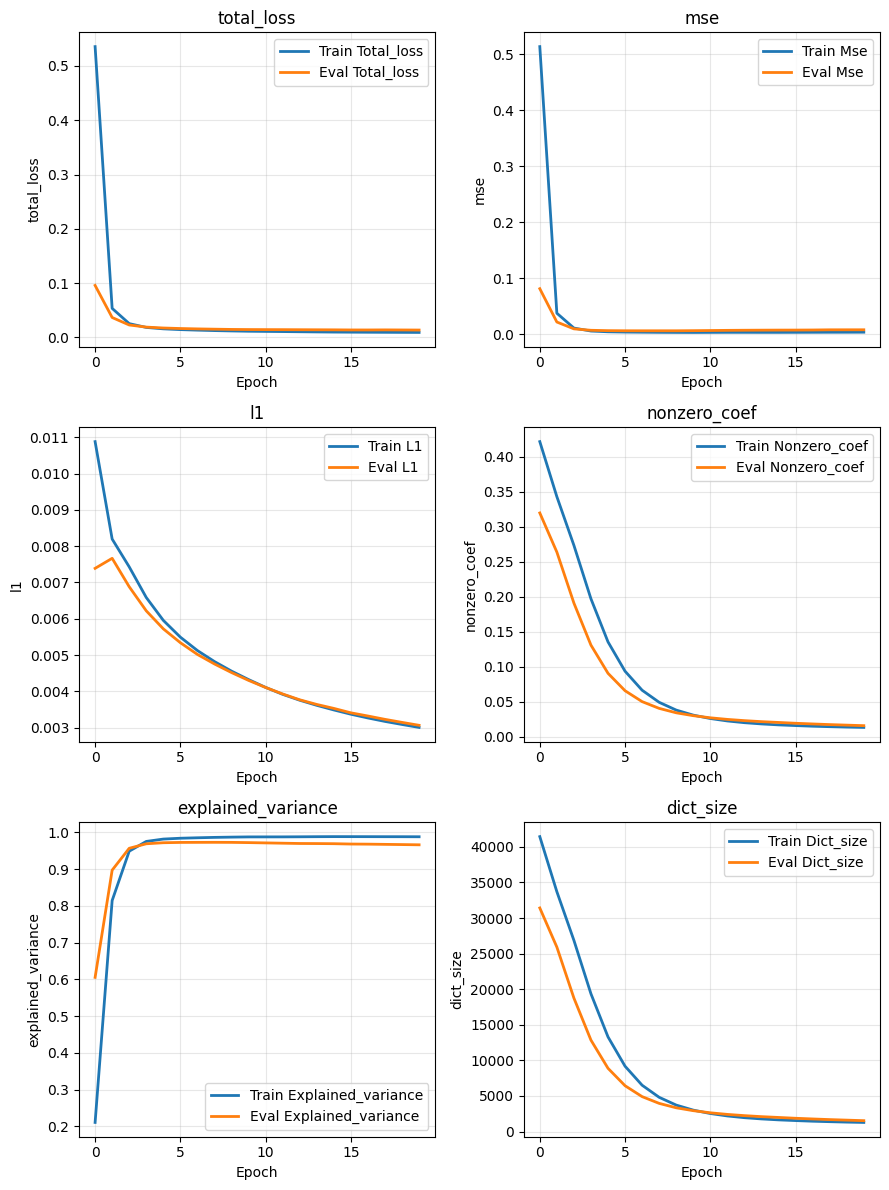

19
total_loss: 0.0137
mse: 0.0076
l1: 0.0031
nonzero_coef: 0.0156
explained_variance: 0.9658
dict_size: 1533.8762


In [ ]:
model = SAE_metrics(CLIP_MODEL_SIZE, LATENT_UPSAMPLE, L1_LAMBDA, dict_threshold=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=3, factor=0.75)
finger = Trainer(
    model,
    optimizer,
    scheduler,
    train_dataloader,
    eval_dataloader,
)

finger.set_num_epochs(20)
finger.train_model()
finger.plot_metrics()
finger.print_metrics()

In [ ]:
finger.save_model_to_dict("../st_dicts/sae_for_clip.pth")

Checkpoint


In [ ]:
train_dataset = JsonDataset("../datasets/sae_for_kandinsky_dataset_train.json", "embedding")
eval_dataset = JsonDataset("../datasets/sae_for_kandinsky_dataset_validation.json", "embedding")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, drop_last=True)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 1
Train | Eval Loss:     8.478086 | 0.947274
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 2
Train | Eval Loss:     0.866689 | 0.810779
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 3
Train | Eval Loss:     0.712865 | 0.690478
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 4
Train | Eval Loss:     0.597566 | 0.606161
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 5
Train | Eval Loss:     0.512934 | 0.541012
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 6
Train | Eval Loss:     0.443058 | 0.485140
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 7
Train | Eval Loss:     0.384211 | 0.434802
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 8
Train | Eval Loss:     0.331478 | 0.388066
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 9
Train | Eval Loss:     0.282005 | 0.343151
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 10
Train | Eval Loss:     0.239813 | 0.300936
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 11
Train | Eval Loss:     0.203886 | 0.266138
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 12
Train | Eval Loss:     0.174734 | 0.235706
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 13
Train | Eval Loss:     0.149844 | 0.209341
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 14
Train | Eval Loss:     0.128998 | 0.186255
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 15
Train | Eval Loss:     0.112060 | 0.167140
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 16
Train | Eval Loss:     0.098596 | 0.151480
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 17
Train | Eval Loss:     0.087542 | 0.137186
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 18
Train | Eval Loss:     0.077649 | 0.124709
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 19
Train | Eval Loss:     0.069361 | 0.113974
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 20
Train | Eval Loss:     0.062700 | 0.105717
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 21
Train | Eval Loss:     0.057484 | 0.099002
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 22
Train | Eval Loss:     0.053159 | 0.093344
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 23
Train | Eval Loss:     0.050119 | 0.090926
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 24
Train | Eval Loss:     0.049473 | 0.093226
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 25
Train | Eval Loss:     0.050822 | 0.096596
LR:                    0.000500


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch:                 26
Train | Eval Loss:     0.051397 | 0.095196
LR:                    0.000500


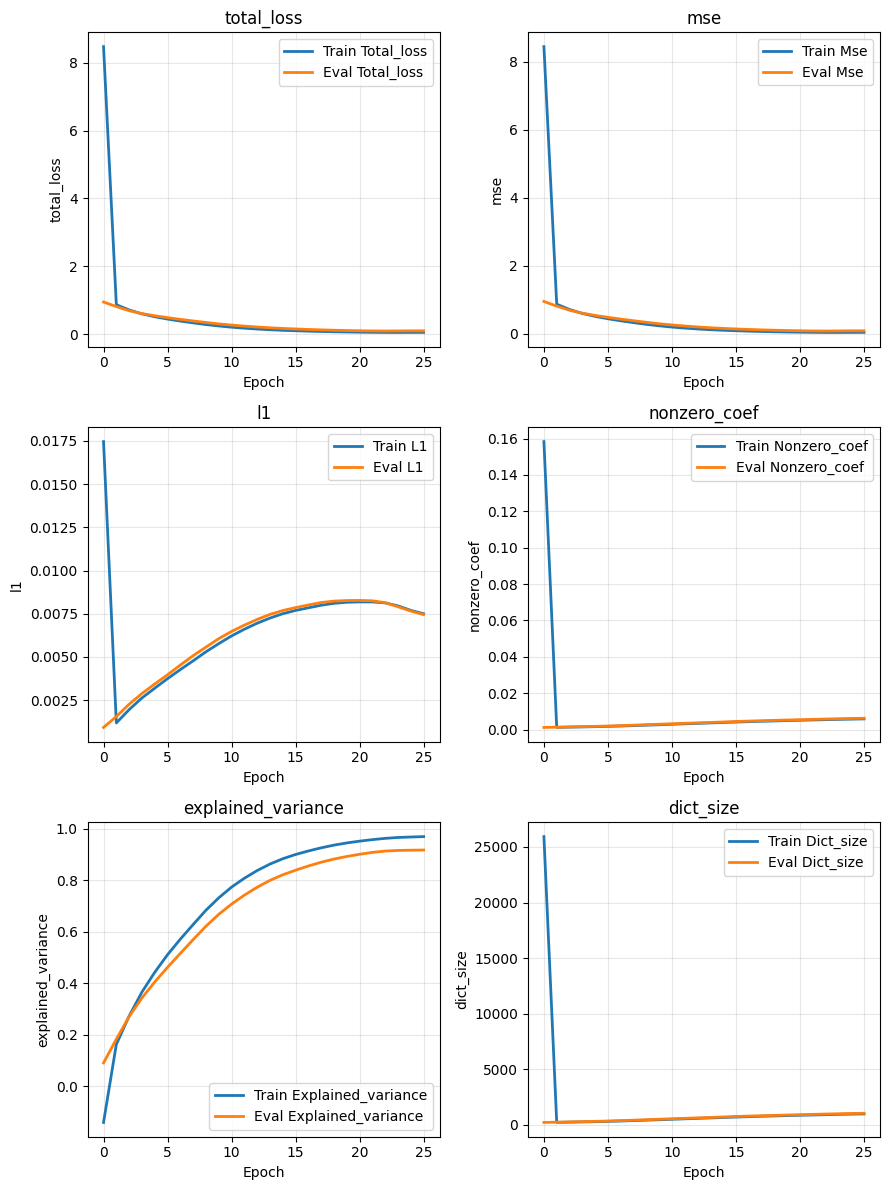

22
total_loss: 0.0909
mse: 0.0746
l1: 0.0081
nonzero_coef: 0.0058
explained_variance: 0.9129
dict_size: 946.7031


In [ ]:
model = SAE_metrics(KANDINSKY_MODEL_SIZE, LATENT_UPSAMPLE, L1_LAMBDA, dict_threshold=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=3, factor=0.75)

finger.set_new_model(model, optimizer, scheduler)
finger.set_num_epochs(30)
finger.train_model()
finger.plot_metrics()
finger.print_metrics()

In [ ]:
finger.save_model_to_dict("../st_dicts/sae_for_kandinsky.pth")

Checkpoint
